# Bikes

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

import pymc as pm
import pymc_bart as pmb

In [2]:
RANDOM_SEED = 8457
rng = np.random.RandomState(RANDOM_SEED)
az.style.use("arviz-white")
plt.rcParams["figure.dpi"] = 300

In [3]:
bikes = pd.read_csv("bikes.csv")

X = bikes[["hour", "temperature", "humidity", "windspeed"]]
Y = bikes["count"]

ordered_var_names = ["hour", "temperature", "humidity", "windspeed"]

In [4]:
idatas = []

for idx in range(X.shape[1]):
    with pm.Model() as model:
        σ = pm.HalfNormal("σ", Y.std())
        μ = pmb.BART("μ", X[ordered_var_names[:idx+1]], Y, m=50)
        y = pm.Normal("y", μ, σ, observed=Y)
        idata = pm.sample(random_seed=RANDOM_SEED)
        idatas.append(idata)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
The acceptance probability does not match the target. It is 0.88, but should be close to 0.8. Try to increase the number of tuning steps.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.


We now check that computing the predictions estimated by pruning the trees is close to the predictions if we actually ommits covariables and refit models

In [5]:
samples = 100

In [6]:
predicted_all = pmb.predict(idatas[-1], rng, X=X.values, size=samples, excluded=None)

ev_mean = np.zeros(len(ordered_var_names))
ev_hdi = np.zeros((len(ordered_var_names), 2))

for idx, idata in enumerate(idatas):
    predicted_subset = pmb.predict(idata,
                                   rng,
                                   X=X[ordered_var_names[:idx+1]].values,
                                   size=samples)
    pearson = np.zeros(samples)
    for j in range(samples):
        pearson[j] = (
            pearsonr(predicted_all[j].flatten(), predicted_subset[j].flatten())[0]
        ) ** 2
    ev_mean[idx] = np.mean(pearson)
    ev_hdi[idx] = az.hdi(pearson)

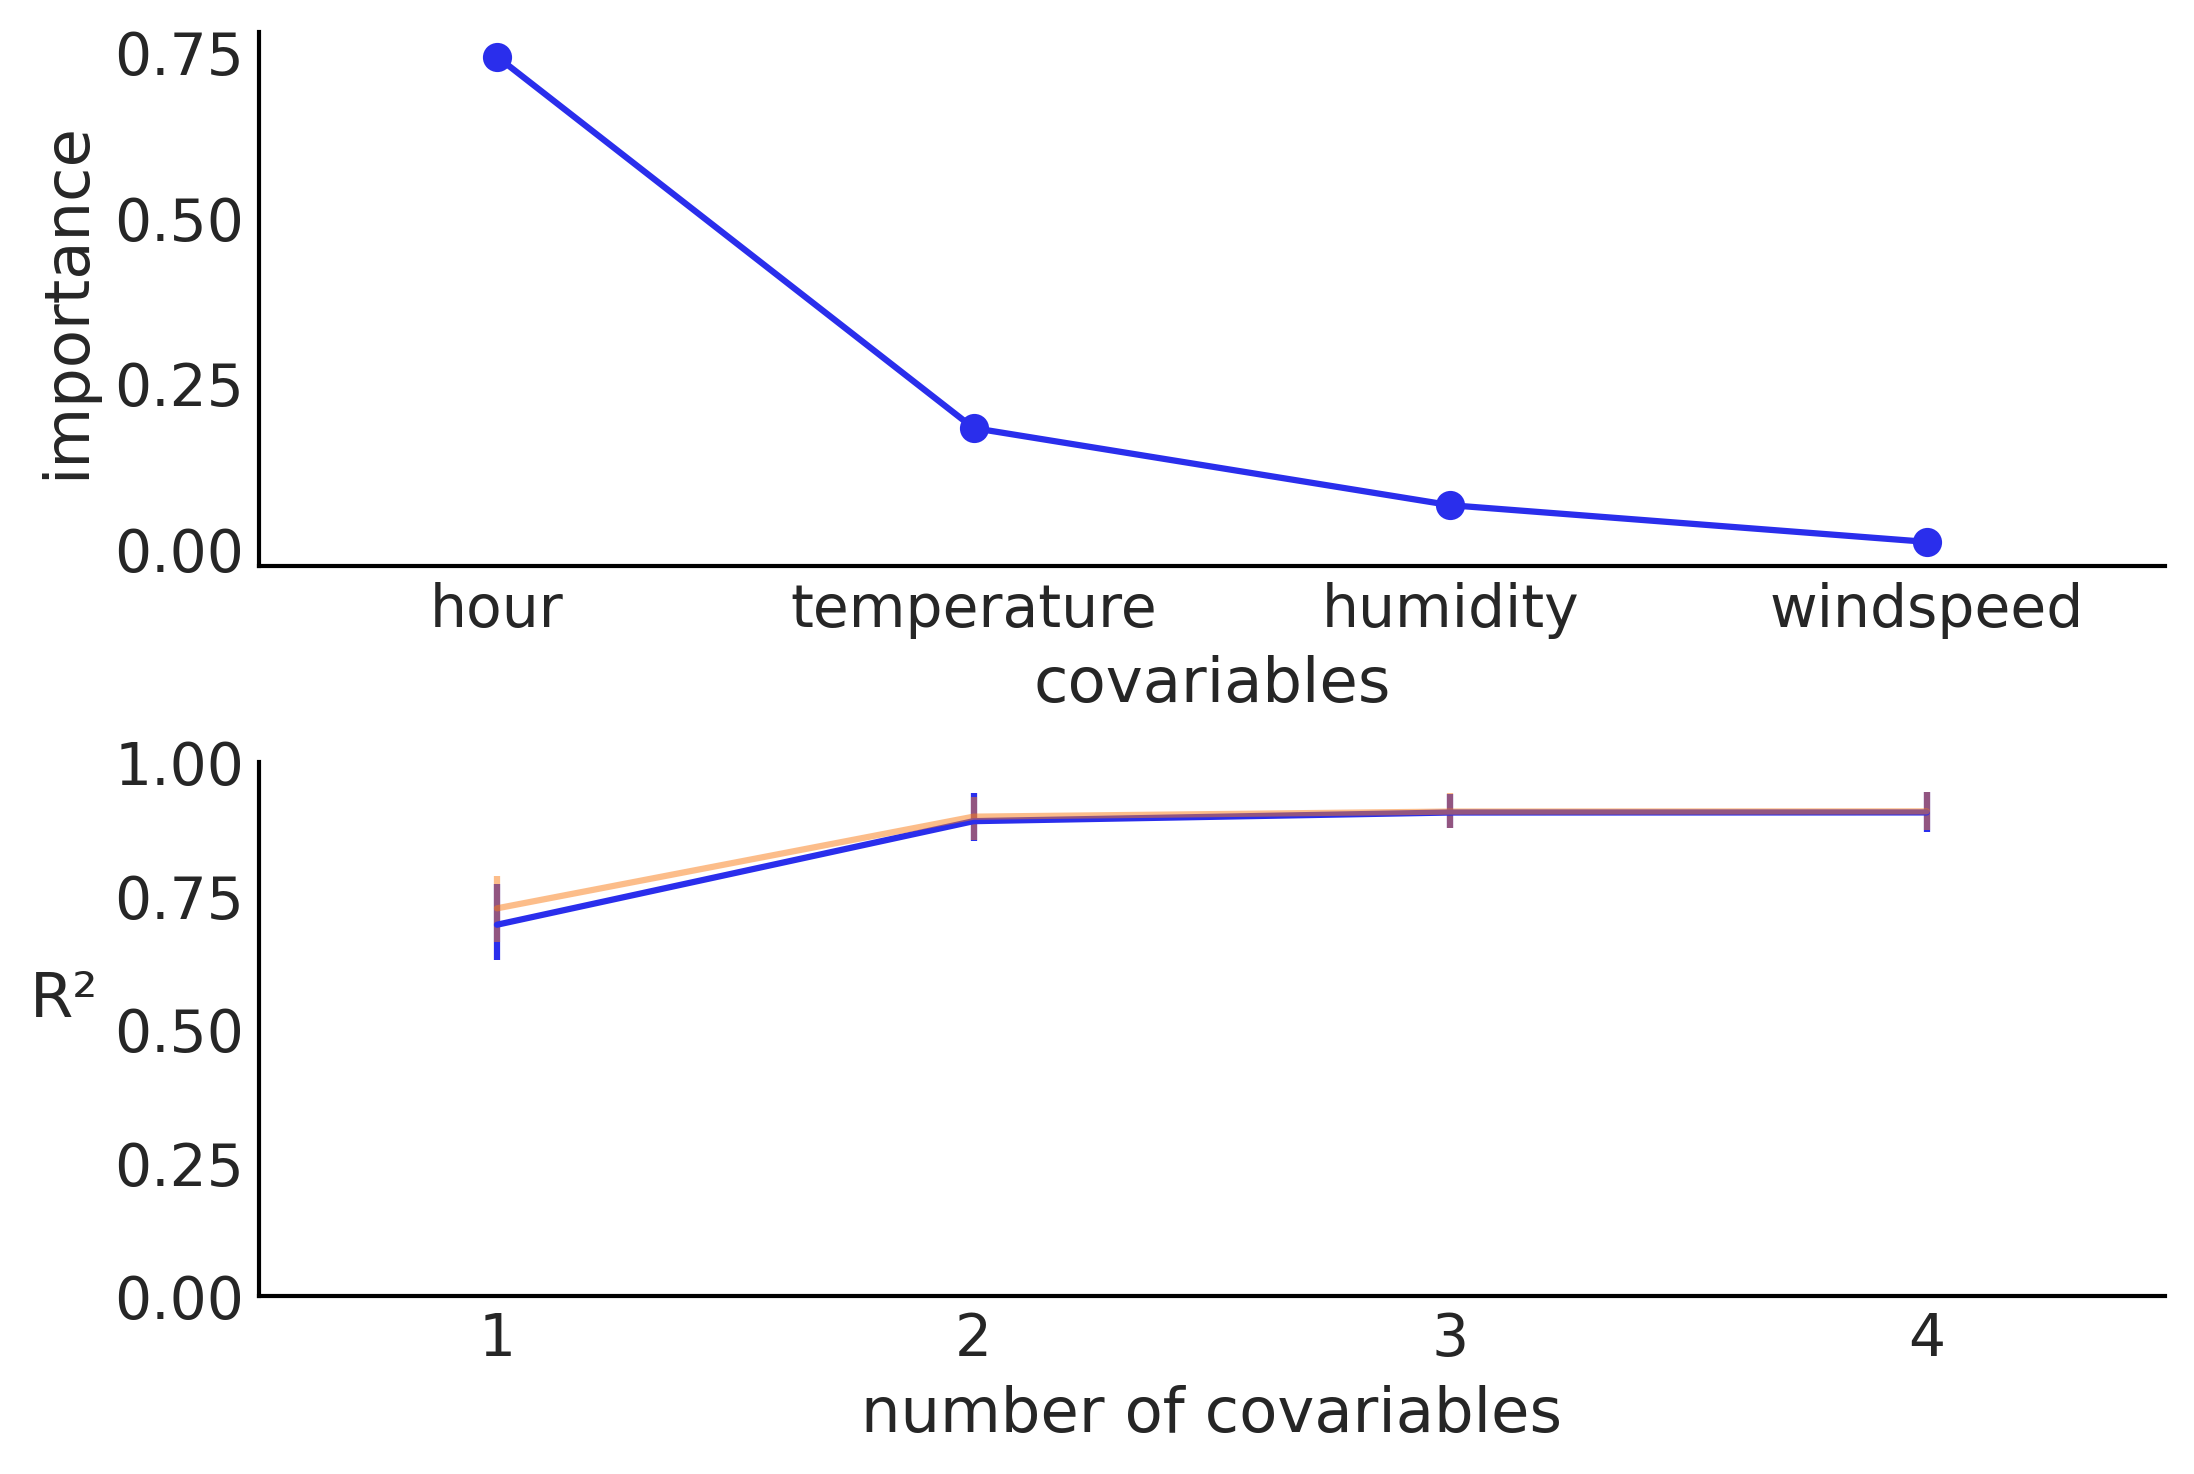

In [7]:
labels = ["hour", "temperature", "humidity", "windspeed"]
axes = pmb.utils.plot_variable_importance(idatas[-1], X.values, labels, samples=samples)

ticks = np.arange(len(ordered_var_names), dtype=int)
plt.errorbar(ticks, ev_mean, np.array((ev_mean - ev_hdi[:, 0], ev_hdi[:, 1] - ev_mean)), alpha=0.5)
plt.savefig("bikes_VI_00.png");